# Nino3.4_check
 - Check that SMYLE Nino3.4 evolution looks reasonable and perform basic skill assessment
 - Author:  S. Yeager

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
from functools import partial
import glob
import dask
import matplotlib.pyplot as plt
%matplotlib inline

# SMYLE Utility functions
from SMYLEutils import io_utils as io
from SMYLEutils import calendar_utils as cal
from SMYLEutils import stat_utils as stat

## Create Dask Cluster

In [74]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
cluster.close()
client.close()

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='10GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=10GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient()
cluster.scale(20) 

In [4]:
cluster

# Main Processing

### Read in POP monthly SST field using I/O functions
- IMPORTANT: User should define preprocessor function appropriately for analysis to follow
- Chosen field is returned as a dask array with leading dimensions of Y (initialization year), M (ensemble member), and L (lead month)
- "time" and "time_bound" variables, which give prediction verification time, are also dimensioned with (Y,L) 

In [5]:
# This preprocessor will return POP SST (first vertical grid level only)
def preprocessor(d0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for your analysis to speed up processing. 
    
    Here,
        - reset monthly time to mid-month value
        - select top vertical level and only nlead time values
        - drop fields unrelated to SST
    """
    d0 = cal.time_set_midmonth(d0,'time')
    d0 = d0.isel(z_t=0).isel(time=slice(0, nlead))
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    d0["time_bound"] = d0.time_bound.expand_dims("Y")
    d0 = d0[[field,'time','time_bound','TLAT','TLONG','TAREA']].drop(['ULAT','ULONG'])
    return d0

In [6]:
%%time
# SMYLE-Nov SST data
# process all 20 ensemble members, all November start dates from 1970-2018:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 11
#chunks={'z_t':1,'nlat':80}
smyle11 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle11.nbytes/1e9 #GB

CPU times: user 27.6 s, sys: 13 s, total: 40.6 s
Wall time: 1min 5s


11.563528492

In [7]:
smyle11

<xarray.Dataset>
Dimensions:     (L: 24, M: 20, Y: 49, d2: 2, nlat: 384, nlon: 320)
Coordinates:
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    z_t         float32 500.0
  * L           (L) int64 1 2 3 4 5 6 7 8 9 10 ... 15 16 17 18 19 20 21 22 23 24
  * Y           (Y) int64 1970 1971 1972 1973 1974 ... 2014 2015 2016 2017 2018
  * M           (M) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    TEMP        (Y, M, L, nlat, nlon) float32 dask.array<chunksize=(1, 1, 24, 384, 320), meta=np.ndarray>
    time        (Y, L) object 1970-11-15 00:00:00 ... 2020-10-15 00:00:00
    time_bound  (Y, L, d2) object dask.array<chunksize=(1, 24, 2), meta=np.ndarray>
    TAREA       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.BSMYLE.f09_g17.1970-11.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2021-05-13 at 15:38:38.2
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [8]:
# Full array can fit in distributed memory, so call persist
# This takes time up front, but speeds things up later
smyle11 = smyle11.persist()

In [9]:
%%time
# SMYLE-Feb SST data
# process all 20 ensemble members, all February start dates from 1970-2018:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 2
#chunks={'z_t':1,'nlat':80}
smyle02 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle02.nbytes/1e9 #GB

CPU times: user 28.9 s, sys: 13.6 s, total: 42.5 s
Wall time: 1min 3s


11.563528492

In [10]:
smyle02 = smyle02.persist()

In [11]:
%%time
# SMYLE-May SST data
# process all 20 ensemble members, all May start dates from 1970-2018:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 5
#chunks={'z_t':1,'nlat':80}
smyle05 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle05.nbytes/1e9 #GB

CPU times: user 30.6 s, sys: 13.4 s, total: 44.1 s
Wall time: 1min 1s


11.563528492

In [12]:
smyle05 = smyle05.persist()

In [13]:
%%time
# SMYLE-Aug SST data
# process all 20 ensemble members, all August start dates from 1970-2018:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 8
#chunks={'z_t':1,'nlat':80}
smyle08 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle08.nbytes/1e9 #GB

CPU times: user 29.9 s, sys: 12.8 s, total: 42.6 s
Wall time: 1min 1s


11.563528492

In [14]:
smyle08 = smyle08.persist()

### Compute Nino3.4 Index

In [15]:
def POP_regional_areawgt(ds,lon_lim,lat_lim):
    tarea = ds.TAREA
    tlat = ds.TLAT
    tlon = xr.where(ds.TLONG>180.,ds.TLONG-360.,ds.TLONG)
    region = (tlat>=lat_lim[0]) & (tlat<=lat_lim[1]) & (tlon>=lon_lim[0]) & (tlon<=lon_lim[1])
    return xr.where(region,tarea.fillna(0),0)

In [16]:
POPg16_nino34_area = POP_regional_areawgt(smyle11,[-170.,-120.],[-5.,5])

Here, perform actual computation, returning xarray:

In [17]:
%%time
smyle11_nino34 = smyle11.TEMP.weighted(POPg16_nino34_area).mean(("nlon", "nlat")).load()
smyle02_nino34 = smyle02.TEMP.weighted(POPg16_nino34_area).mean(("nlon", "nlat")).load()
smyle05_nino34 = smyle05.TEMP.weighted(POPg16_nino34_area).mean(("nlon", "nlat")).load()
smyle08_nino34 = smyle08.TEMP.weighted(POPg16_nino34_area).mean(("nlon", "nlat")).load()

CPU times: user 16.4 s, sys: 259 ms, total: 16.7 s
Wall time: 16.7 s


In [18]:
# Observed Nino3.4 (NOAA ERSSTv5)
ds_obs = xr.open_dataset('/glade/campaign/cesm/development/espwg/verification_datasets/mon/SST/ersst.v5.188001-202012.nc',decode_times=False)
obs_time_vals = [cftime.DatetimeNoLeap(1880+year, 1+month, 15) for year in range(141) for month in range(12)]
ds_obs['time'] = obs_time_vals
obs_sst_tmp = ds_obs.sst.sel(lat=slice(-5,5)).sel(lon=slice(360-170,360-120))
obs_wgts = np.cos(np.deg2rad(obs_sst_tmp.lat))
obs_nino34 = obs_sst_tmp.weighted(obs_wgts).mean(("lon", "lat")).load()

### Generate Time Series Plot
#### Check that individual members (blue) emerge from behind ensemble mean (red) as lead time increases

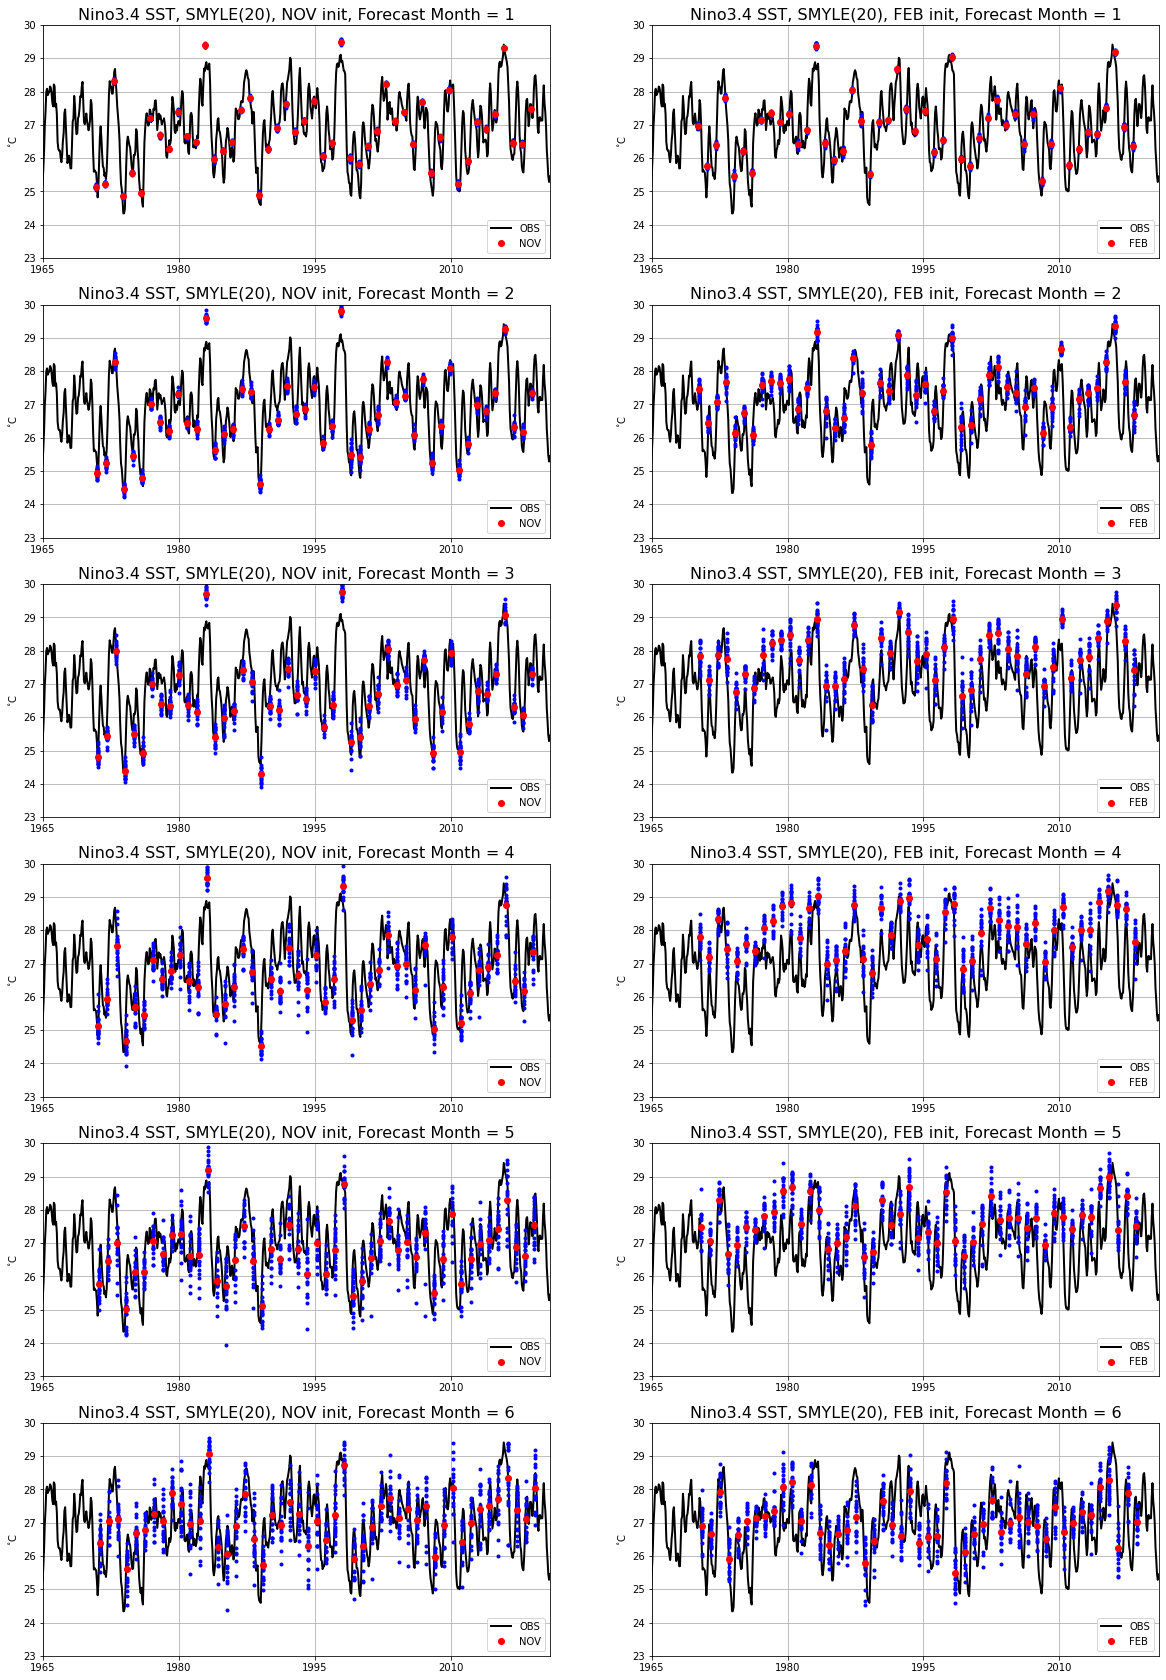

In [20]:
nlead = 6
fig = plt.figure(figsize=(20, nlead*5))
nrow = nlead
ncol = 2

xtickyears = [1960,1965,1975,1985,1995,2005,2015]
xticks = [cftime.num2date(0, 'days since '+str(i)+'-01-01 00:00:00', calendar='noleap') for i in xtickyears]
xmin = cftime.num2date(0, 'days since 1965-01-01 00:00:00', calendar='noleap')
xmax = cftime.num2date(0, 'days since 2021-01-01 00:00:00', calendar='noleap')

for i in range(nlead):
    thislead = i+1
    smyle11time = smyle11.time.sel(L=thislead)
    ax = fig.add_subplot(nrow,ncol,i*ncol+1)
    ax.plot(obs_nino34.time, obs_nino34,linewidth=2,color='k',label='OBS')
    ax.plot(smyle11time,smyle11_nino34.sel(L=thislead),'.',color='b')
    ax.plot(smyle11time,smyle11_nino34.sel(L=thislead).mean('M'),'o',color='r',label='NOV')
    ax.grid()
    icstr = 'NOV'
    ax.set_title('Nino3.4 SST, SMYLE(20), {} init, Forecast Month = {}'.format(icstr,thislead), fontdict={'size':16})
    ax.set_ylabel(r'$^{\circ}$C')
    ax.set_ylim(23,30)
    ax.set_xlim(xmin,xmax)
#    ax.set_xticks(xtickyears)
    ax.legend(loc='lower right')
    
    smyle02time = smyle02.time.sel(L=thislead)
    ax = fig.add_subplot(nrow,ncol,i*ncol+2)
    ax.plot(obs_nino34.time, obs_nino34,linewidth=2,color='k',label='OBS')
    ax.plot(smyle02time,smyle02_nino34.sel(L=thislead),'.',color='b')
    ax.plot(smyle02time,smyle02_nino34.sel(L=thislead).mean('M'),'o',color='r',label='FEB')
    ax.grid()
    icstr = 'FEB'
    ax.set_title('Nino3.4 SST, SMYLE(20), {} init, Forecast Month = {}'.format(icstr,thislead), fontdict={'size':16})
    ax.set_ylabel(r'$^{\circ}$C')
    ax.set_ylim(23,30)
    ax.set_xlim(xmin,xmax)
#    ax.set_xticks(xtickyears)
    ax.legend(loc='lower right')

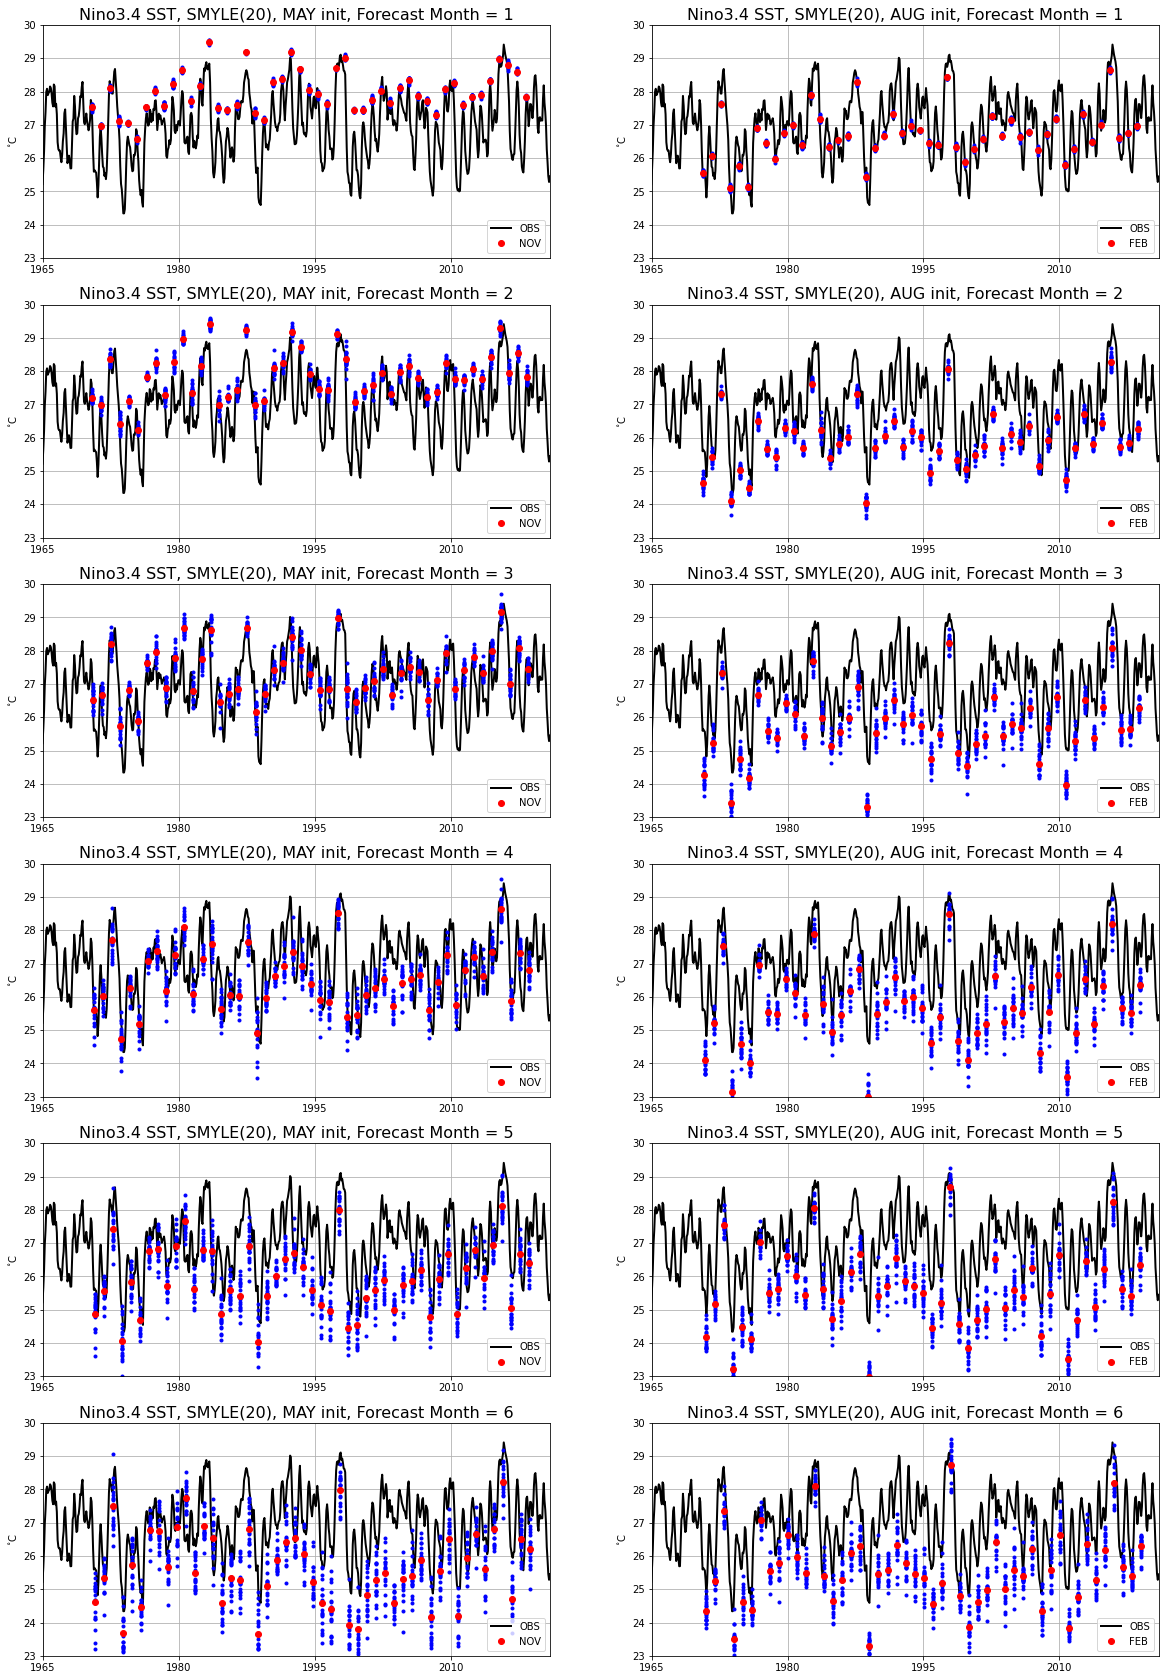

In [21]:
nlead = 6
fig = plt.figure(figsize=(20, nlead*5))
nrow = nlead
ncol = 2

xtickyears = [1960,1965,1975,1985,1995,2005,2015]
xticks = [cftime.num2date(0, 'days since '+str(i)+'-01-01 00:00:00', calendar='noleap') for i in xtickyears]
xmin = cftime.num2date(0, 'days since 1965-01-01 00:00:00', calendar='noleap')
xmax = cftime.num2date(0, 'days since 2021-01-01 00:00:00', calendar='noleap')

for i in range(nlead):
    thislead = i+1
    smyle05time = smyle05.time.sel(L=thislead)
    ax = fig.add_subplot(nrow,ncol,i*ncol+1)
    ax.plot(obs_nino34.time, obs_nino34,linewidth=2,color='k',label='OBS')
    ax.plot(smyle05time,smyle05_nino34.sel(L=thislead),'.',color='b')
    ax.plot(smyle05time,smyle05_nino34.sel(L=thislead).mean('M'),'o',color='r',label='NOV')
    ax.grid()
    icstr = 'MAY'
    ax.set_title('Nino3.4 SST, SMYLE(20), {} init, Forecast Month = {}'.format(icstr,thislead), fontdict={'size':16})
    ax.set_ylabel(r'$^{\circ}$C')
    ax.set_ylim(23,30)
    ax.set_xlim(xmin,xmax)
#    ax.set_xticks(xtickyears)
    ax.legend(loc='lower right')
    
    smyle08time = smyle08.time.sel(L=thislead)
    ax = fig.add_subplot(nrow,ncol,i*ncol+2)
    ax.plot(obs_nino34.time, obs_nino34,linewidth=2,color='k',label='OBS')
    ax.plot(smyle08time,smyle08_nino34.sel(L=thislead),'.',color='b')
    ax.plot(smyle08time,smyle08_nino34.sel(L=thislead).mean('M'),'o',color='r',label='FEB')
    ax.grid()
    icstr = 'AUG'
    ax.set_title('Nino3.4 SST, SMYLE(20), {} init, Forecast Month = {}'.format(icstr,thislead), fontdict={'size':16})
    ax.set_ylabel(r'$^{\circ}$C')
    ax.set_ylim(23,30)
    ax.set_xlim(xmin,xmax)
#    ax.set_xticks(xtickyears)
    ax.legend(loc='lower right')

### Generate Correlation Skill Plot

In [24]:
def leadtime_corr(mod_da,mod_time,obs_da):
    """ 
    Computes the correlation coefficient between two xarray DataArrays, which 
    must share the same lat/lon coordinates (if any). Assumes time coordinates are roughly compatible
    between model and obs.
    
        Inputs
        mod_da: a SMYLE DataArray dimensioned (Y,M,L,...)
        obs_da: an OBS DataArray dimensioned (time,...)
        mod_time: a SMYLE time DataArray dimensioned (Y,L)
    """
    ens = mod_da.mean('M')
    corr_list = []
    for i in ens.L.values:
        ens_ts = ens.sel(L=i).rename({'Y':'time'})
        ens_time = mod_time.sel(L=i)
        ens_ts = ens_ts.assign_coords(time=("time",ens_time))
        a,b = xr.align(ens_ts,obs_da)
        corr_list.append(xr.corr(a,b))
    corr = xr.concat(corr_list,ens.L)
    return corr

In [25]:
%%time
# Correlation as a function of forecast lead month:
smyle11_ccoef = leadtime_corr(smyle11_nino34,smyle11.time,obs_nino34)
smyle02_ccoef = leadtime_corr(smyle02_nino34,smyle02.time,obs_nino34)
smyle05_ccoef = leadtime_corr(smyle05_nino34,smyle05.time,obs_nino34)
smyle08_ccoef = leadtime_corr(smyle08_nino34,smyle08.time,obs_nino34)

CPU times: user 617 ms, sys: 5.08 ms, total: 622 ms
Wall time: 777 ms


In [26]:
%%time
# Remove leadtime-dependent drift
smyle11_nino34_dd,smyle11_nino34_drift = stat.remove_drift(smyle11_nino34,smyle11.time,1972,2018)
smyle02_nino34_dd,smyle02_nino34_drift = stat.remove_drift(smyle02_nino34,smyle02.time,1972,2018)
smyle05_nino34_dd,smyle05_nino34_drift = stat.remove_drift(smyle05_nino34,smyle05.time,1972,2018)
smyle08_nino34_dd,smyle08_nino34_drift = stat.remove_drift(smyle08_nino34,smyle08.time,1972,2018)

CPU times: user 12.6 ms, sys: 95 µs, total: 12.7 ms
Wall time: 34.4 ms


In [27]:
%%time
# Correlation as a function of forecast lead month:
smyle11_ccoef_dd = leadtime_corr(smyle11_nino34_dd,smyle11.time,obs_nino34)
smyle02_ccoef_dd = leadtime_corr(smyle02_nino34_dd,smyle02.time,obs_nino34)
smyle05_ccoef_dd = leadtime_corr(smyle05_nino34_dd,smyle05.time,obs_nino34)
smyle08_ccoef_dd = leadtime_corr(smyle08_nino34_dd,smyle08.time,obs_nino34)

CPU times: user 606 ms, sys: 3.41 ms, total: 609 ms
Wall time: 602 ms


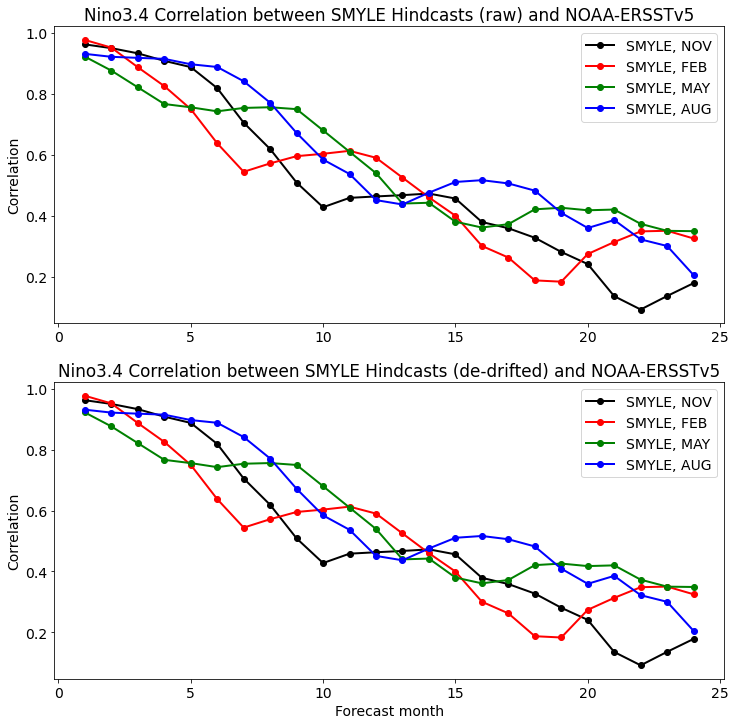

In [30]:
# plot correlation
fig = plt.figure(figsize=(12,12))
plt.rcParams['font.size'] = '14'
#ax = fig.add_subplot(nrow,ncol,subplot, projection=proj)
ax = fig.add_subplot(2,1,1)
ax.set_ylabel('Correlation', fontsize=14)
#ax.set_xlabel('Forecast month')
ax.set_title('Nino3.4 Correlation between SMYLE Hindcasts (raw) and NOAA-ERSSTv5')
ax.plot(smyle11_ccoef.L,smyle11_ccoef,color='k', marker='o',linewidth=2,label='SMYLE, NOV')
ax.plot(smyle02_ccoef.L,smyle02_ccoef,color='r', marker='o',linewidth=2,label='SMYLE, FEB')
ax.plot(smyle05_ccoef.L,smyle05_ccoef,color='g', marker='o',linewidth=2,label='SMYLE, MAY')
ax.plot(smyle08_ccoef.L,smyle08_ccoef,color='b', marker='o',linewidth=2,label='SMYLE, AUG')
ax.legend(loc='upper right')

ax = fig.add_subplot(2,1,2)
ax.set_ylabel('Correlation', fontsize=14)
ax.set_xlabel('Forecast month')
ax.set_title('Nino3.4 Correlation between SMYLE Hindcasts (de-drifted) and NOAA-ERSSTv5')
ax.plot(smyle11_ccoef_dd.L,smyle11_ccoef_dd,color='k', marker='o',linewidth=2,label='SMYLE, NOV')
ax.plot(smyle02_ccoef_dd.L,smyle02_ccoef_dd,color='r', marker='o',linewidth=2,label='SMYLE, FEB')
ax.plot(smyle05_ccoef_dd.L,smyle05_ccoef_dd,color='g', marker='o',linewidth=2,label='SMYLE, MAY')
ax.plot(smyle08_ccoef_dd.L,smyle08_ccoef_dd,color='b', marker='o',linewidth=2,label='SMYLE, AUG')
ax.legend(loc='upper right')

#plt.savefig('SMYLE_Nino3.4_corrskill_allmons.eps')

##### Note that removing leadtime-dependent drift does not impact correlation scores.

### Generate RMSE Skill Plot

In [57]:
def leadtime_rmse(mod_da,mod_time,obs_da):
    """ 
    Computes the RMS difference between two xarray DataArrays, which 
    must share the same lat/lon coordinates (if any). Assumes time coordinates are roughly compatible
    between model and obs.
    
        Inputs
        mod_da: a SMYLE DataArray dimensioned (Y,M,L,...)
        obs_da: an OBS DataArray dimensioned (time,...)
        mod_time: a SMYLE time DataArray dimensioned (Y,L)
    """
    ens = mod_da.mean('M')
    rmse_list = []
    for i in ens.L.values:
        ens_ts = ens.sel(L=i).rename({'Y':'time'})
        ens_time = mod_time.sel(L=i)
        ens_ts = ens_ts.assign_coords(time=("time",ens_time))
        a,b = xr.align(ens_ts,obs_da)
        rmse = np.sqrt(((a - b) ** 2).mean('time'))
        rmse_list.append(rmse)
    rmse_da = xr.concat(rmse_list,ens.L)
    return rmse_da

In [58]:
%%time
# RMSE as a function of forecast lead month:
smyle11_rmse = leadtime_rmse(smyle11_nino34,smyle11.time,obs_nino34)
smyle02_rmse = leadtime_rmse(smyle02_nino34,smyle02.time,obs_nino34)
smyle05_rmse = leadtime_rmse(smyle05_nino34,smyle05.time,obs_nino34)
smyle08_rmse = leadtime_rmse(smyle08_nino34,smyle08.time,obs_nino34)

CPU times: user 414 ms, sys: 6.77 ms, total: 421 ms
Wall time: 416 ms


In [67]:
%%time
# Note: To compute the de-drifted RMSE, the OBS reference should be monthly anomalies from the same 
#       climatology that was used for de-drifting, with the seasonal cycle removed!
tmp = obs_nino34.sel(time=slice("1972","2018")).groupby('time.month').mean('time')
obs_nino34_anom = obs_nino34.groupby('time.month') - tmp

# RMSE as a function of forecast lead month:
smyle11_rmse_dd = leadtime_rmse(smyle11_nino34_dd,smyle11.time,obs_nino34_anom)
smyle02_rmse_dd = leadtime_rmse(smyle02_nino34_dd,smyle02.time,obs_nino34_anom)
smyle05_rmse_dd = leadtime_rmse(smyle05_nino34_dd,smyle05.time,obs_nino34_anom)
smyle08_rmse_dd = leadtime_rmse(smyle08_nino34_dd,smyle08.time,obs_nino34_anom)

CPU times: user 455 ms, sys: 7.6 ms, total: 462 ms
Wall time: 457 ms


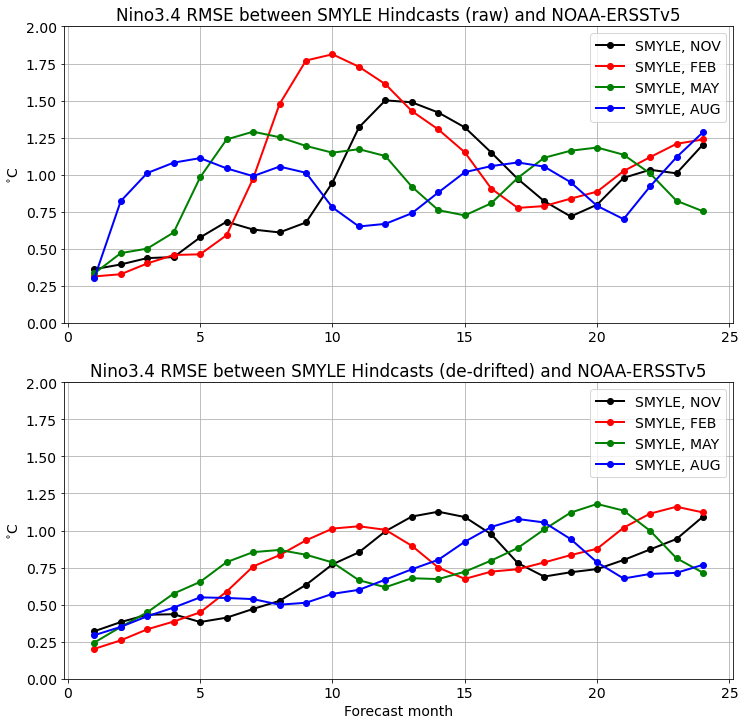

In [68]:
# plot RMSE
fig = plt.figure(figsize=(12,12))
plt.rcParams['font.size'] = '14'
#ax = fig.add_subplot(nrow,ncol,subplot, projection=proj)
ax = fig.add_subplot(2,1,1)
ax.set_ylabel(r'$^{\circ}$C')
ax.set_ylim(0,2)
ax.set_title('Nino3.4 RMSE between SMYLE Hindcasts (raw) and NOAA-ERSSTv5')
ax.plot(smyle11_rmse.L,smyle11_rmse,color='k', marker='o',linewidth=2,label='SMYLE, NOV')
ax.plot(smyle02_rmse.L,smyle02_rmse,color='r', marker='o',linewidth=2,label='SMYLE, FEB')
ax.plot(smyle05_rmse.L,smyle05_rmse,color='g', marker='o',linewidth=2,label='SMYLE, MAY')
ax.plot(smyle08_rmse.L,smyle08_rmse,color='b', marker='o',linewidth=2,label='SMYLE, AUG')
ax.grid()
ax.legend(loc='upper right')

ax = fig.add_subplot(2,1,2)
ax.set_ylabel(r'$^{\circ}$C')
ax.set_ylim(0,2)
ax.set_xlabel('Forecast month')
ax.set_title('Nino3.4 RMSE between SMYLE Hindcasts (de-drifted) and NOAA-ERSSTv5')
ax.plot(smyle11_rmse_dd.L,smyle11_rmse_dd,color='k', marker='o',linewidth=2,label='SMYLE, NOV')
ax.plot(smyle02_rmse_dd.L,smyle02_rmse_dd,color='r', marker='o',linewidth=2,label='SMYLE, FEB')
ax.plot(smyle05_rmse_dd.L,smyle05_rmse_dd,color='g', marker='o',linewidth=2,label='SMYLE, MAY')
ax.plot(smyle08_rmse_dd.L,smyle08_rmse_dd,color='b', marker='o',linewidth=2,label='SMYLE, AUG')
ax.grid()
ax.legend(loc='upper right')

#plt.savefig('SMYLE_Nino3.4_corrskill_allmons.eps')

##### Note that removing leadtime-dependent drift **does** impact RMSE scores.

### Examine Leadtime-dependent Climatological Bias (i.e., Drift)

In [69]:
def leadtime_bias(mod_da,mod_time,obs_da,y1,y2):
    """ 
    Computes the climatological difference between two xarray DataArrays, which 
    must share the same lat/lon coordinates (if any). Assumes time coordinates are roughly compatible
    between model and obs.
    
        Inputs
        mod_da: a SMYLE DataArray dimensioned (Y,M,L,...)
        obs_da: an OBS DataArray dimensioned (time,...)
        mod_time: a SMYLE time DataArray dimensioned (Y,L)
        y1,y2:  Years that define climatology
    """
    d1 = cftime.DatetimeNoLeap(y1,1,1,0,0,0)
    d2 = cftime.DatetimeNoLeap(y2,12,31,23,59,59)
    ens = mod_da.mean('M')
    bias_list = []
    for i in ens.L.values:
        ens_ts = ens.sel(L=i).rename({'Y':'time'})
        ens_time = mod_time.sel(L=i)
        ens_ts = ens_ts.assign_coords(time=("time",ens_time))
        a,b = xr.align(ens_ts,obs_da)
        diff = a - b
        meandiff = diff.where((diff.time>d1) & (diff.time<d2)).mean('time')
        bias_list.append(meandiff)
    bias_da = xr.concat(bias_list,ens.L)
    return bias_da

In [70]:
%%time
# Bias as a function of forecast lead month:
smyle11_bias = leadtime_bias(smyle11_nino34,smyle11.time,obs_nino34,1972,2018)
smyle02_bias = leadtime_bias(smyle02_nino34,smyle02.time,obs_nino34,1972,2018)
smyle05_bias = leadtime_bias(smyle05_nino34,smyle05.time,obs_nino34,1972,2018)
smyle08_bias = leadtime_bias(smyle08_nino34,smyle08.time,obs_nino34,1972,2018)

CPU times: user 496 ms, sys: 5.71 ms, total: 501 ms
Wall time: 496 ms


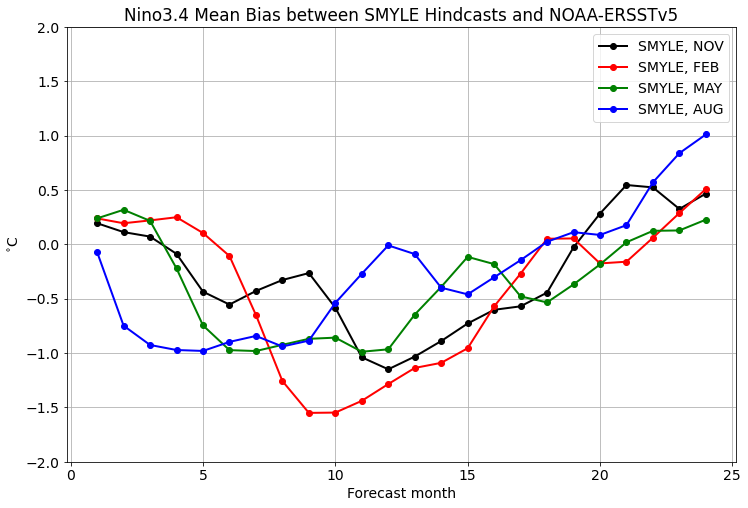

In [73]:
# plot Bias
fig = plt.figure(figsize=(12,8))
plt.rcParams['font.size'] = '14'
ax = fig.add_subplot(1,1,1)
ax.set_ylabel(r'$^{\circ}$C')
ax.set_ylim(-2,2)
ax.set_title('Nino3.4 Mean Bias between SMYLE Hindcasts and NOAA-ERSSTv5')
ax.plot(smyle11_bias.L,smyle11_bias,color='k', marker='o',linewidth=2,label='SMYLE, NOV')
ax.plot(smyle02_bias.L,smyle02_bias,color='r', marker='o',linewidth=2,label='SMYLE, FEB')
ax.plot(smyle05_bias.L,smyle05_bias,color='g', marker='o',linewidth=2,label='SMYLE, MAY')
ax.plot(smyle08_bias.L,smyle08_bias,color='b', marker='o',linewidth=2,label='SMYLE, AUG')
ax.set_xlabel('Forecast month')
ax.grid()
ax.legend(loc='upper right')